## Background

A marketing agency has many customers that use their service to produce ads for the client/customer websites. They've noticed that they have quite a bit of churn in clients. They basically randomly assign account managers right now, but want you to create a machine learning model that will help predict which customers will churn (stop buying their service) so that they can correctly assign the customers most at risk to churn an account manager. 

The data is saved as customer_churn.csv. Here are the fields and their definitions:

    Name : Name of the latest contact at Company
    Age: Customer Age
    Total_Purchase: Total Ads Purchased
    Account_Manager: Binary 0=No manager, 1= Account manager assigned
    Years: Totaly Years as a customer
    Num_sites: Number of websites that use the service.
    Onboard_date: Date that the name of the latest contact was onboarded
    Location: Client HQ Address
    Company: Name of Client Company
    


First we import the libraries that we'll need

In [98]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import format_number, col, desc,udf, count, sum
from pyspark.ml.feature import VectorAssembler, QuantileDiscretizer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import DoubleType 
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

Next we start a new Spark session and read in the data which is stores in a CSV fromat on HDFS

In [4]:
spark = SparkSession.builder.appName('churn').getOrCreate()

In [5]:
churn_data = spark.read.csv('/user/a208669/customer_churn.csv',inferSchema=True,header=True)

We quickly have a look at the variables and variable types to see whether it was succcesfully imported

In [6]:
churn_data.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)



Next we can have a look at the first row of the data 

In [7]:
churn_data.take(1)

[Row(Names='Cameron Williams', Age=42.0, Total_Purchase=11066.8, Account_Manager=0, Years=7.22, Num_Sites=8.0, Onboard_date=datetime.datetime(2013, 8, 30, 7, 0, 40), Location='10265 Elizabeth Mission Barkerburgh, AK 89518', Company='Harvey LLC', Churn=1)]

Next we can draw up some summary statistics of the numerical variables

In [8]:
num_col = [item[0] for item in churn_data.dtypes if item[1] != 'string' and item[1] != 'timestamp']

In [333]:
print(num_col)

['Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites', 'Churn']


In [9]:
summary_data = churn_data.select(num_col).describe().cache()

In [10]:
summary_data.show()

+-------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|summary|              Age|   Total_Purchase|   Account_Manager|            Years|         Num_Sites|              Churn|
+-------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|  count|              900|              900|               900|              900|               900|                900|
|   mean|41.81666666666667|10062.82403333334|0.4811111111111111| 5.27315555555555| 8.587777777777777|0.16666666666666666|
| stddev|6.127560416916251|2408.644531858096|0.4999208935073339|1.274449013194616|1.7648355920350969| 0.3728852122772358|
|    min|             22.0|            100.0|                 0|              1.0|               3.0|                  0|
|    max|             65.0|         18026.01|                 1|             9.15|              14.0|                  1|
+-------+---------------

Let's format the table so that only the first 2 decimals values are displayed 

In [11]:
summary_data2 = summary_data.select(summary_data['summary'],*(format_number(col(c).cast("float"),2).alias(c) for c in num_col))

In [12]:
summary_data2.show()

+-------+------+--------------+---------------+------+---------+------+
|summary|   Age|Total_Purchase|Account_Manager| Years|Num_Sites| Churn|
+-------+------+--------------+---------------+------+---------+------+
|  count|900.00|        900.00|         900.00|900.00|   900.00|900.00|
|   mean| 41.82|     10,062.82|           0.48|  5.27|     8.59|  0.17|
| stddev|  6.13|      2,408.64|           0.50|  1.27|     1.76|  0.37|
|    min| 22.00|        100.00|           0.00|  1.00|     3.00|  0.00|
|    max| 65.00|     18,026.01|           1.00|  9.15|    14.00|  1.00|
+-------+------+--------------+---------------+------+---------+------+



From the above table we see that around 17% of customers have churned. Next we'll have a look at the Locaction column to see whether it's usable in our model

In [25]:
churn_data.groupBy('Location').count().orderBy(desc('count')).show(n=20,truncate=False)

+---------------------------------------------------------------+-----+
|Location                                                       |count|
+---------------------------------------------------------------+-----+
|7259 Brown Street Apt. 385 Monicaport, GU 05916-8374           |1    |
|404 Joshua Estate Apt. 074 Jacobsonside, CT 88758-3164         |1    |
|243 Laura Gateway Mitchellport, FL 53705-6256                  |1    |
|81459 Sarah Brook Suite 370 Lake Michael, MA 20035-7310        |1    |
|512 Wesley Stream West Scottborough, ND 44332-3438             |1    |
|513 Bullock Alley New Diane, NM 39999                          |1    |
|00154 Ashley Course Shannonville, UT 52907                     |1    |
|062 Trevor Falls Suite 665 North Mathewchester, MH 93744       |1    |
|066 Jenkins Walks Barbaramouth, LA 76409                       |1    |
|30668 Isabella Freeway Suite 428 Lake Kellyhaven, MP 89074-5017|1    |
|911 Kent Point Anthonytown, KS 47499                           

We can text mine the State as a second iteration to the model. But for now we'll discount this field. Next we'll draw some histograms of the variables. Since there are only 900 observations in this data set (this data set is used purely for illustration purposes to show the capabilities of Spark) we can easily convert this Data frame to a panda Data frame. In the case of billion of records, I woud suggest drawing a random sample of the data for plotting purposes

In [26]:
churn_panda_df = churn_data.toPandas()


In [27]:
x_vars = [var for var in num_col if var != 'Account_Manager' and var != 'Churn']

In [28]:
x_vars

['Age', 'Total_Purchase', 'Years', 'Num_Sites']

/opt/anaconda2/envs/py345/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


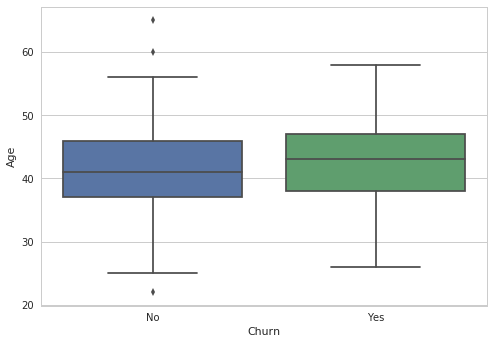

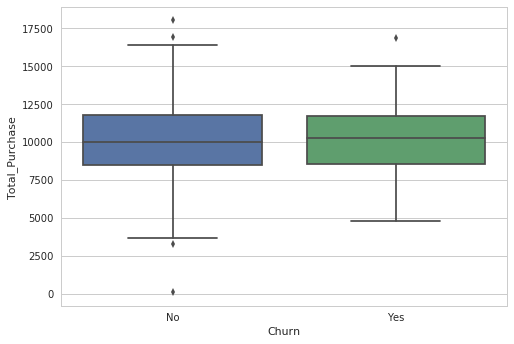

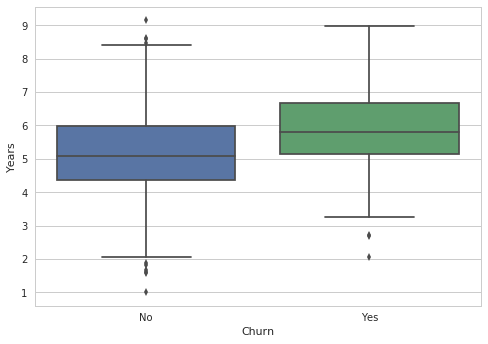

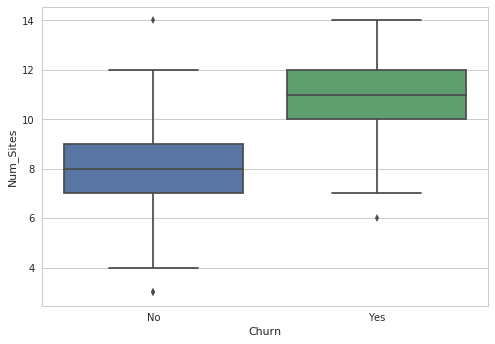

In [162]:
for var in x_vars:
    sns.set_style("whitegrid")     
    bp = sns.boxplot(x='Churn',y=var,data=churn_panda_df)
    bp.set_xticklabels(["No", "Yes"])
    sns.plt.show()
plt.close()

From the above plots, we can see the Num_Sites, Years and age may be predictive of churn behaviour. Next we make use of the  VectorAssembler function to put the data in the required format that Spark expects- two columns with the names "label" and "features". The "label" column then needs to have the numerical label, either a regression numerical value, or a numerical value that matches to a classification grouping. The feature column has inside of it a vector of all the features that belong to that row. 

In [30]:
assembler = VectorAssembler(inputCols= x_vars,outputCol='features')
model_input_data = assembler.transform(churn_data)

In [32]:
model_input_data.select('features').show(n=10,truncate=False)

+-------------------------+
|features                 |
+-------------------------+
|[42.0,11066.8,7.22,8.0]  |
|[41.0,11916.22,6.5,11.0] |
|[38.0,12884.75,6.67,12.0]|
|[42.0,8010.76,6.71,10.0] |
|[37.0,9191.58,5.56,9.0]  |
|[48.0,10356.02,5.12,8.0] |
|[44.0,11331.58,5.23,11.0]|
|[32.0,9885.12,6.92,9.0]  |
|[43.0,14062.6,5.46,11.0] |
|[40.0,8066.94,7.11,11.0] |
+-------------------------+
only showing top 10 rows



Next we split the dataset into a training and test dataset. We use a 70/30% training/test split

In [33]:
train_data, test_data = model_input_data.select(['features','Churn']).randomSplit([0.7,0.3],seed=1357)

No we can fit the model to the training data!

In [34]:
lr_model = LogisticRegression(featuresCol = 'features',labelCol= 'Churn',).fit(train_data)

Let's create a new object containing some of the summary measures of this model. And look at some stas on the predicted value 

In [35]:
training_sum = lr_model.summary

In [274]:
training_sum.predictions.describe().show()

+-------+-------------------+-------------------+
|summary|              Churn|         prediction|
+-------+-------------------+-------------------+
|  count|                626|                626|
|   mean|0.16293929712460065| 0.1134185303514377|
| stddev| 0.3696056096831665|0.31735729856437317|
|    min|                0.0|                0.0|
|    max|                1.0|                1.0|
+-------+-------------------+-------------------+



Next we'll evaluate this model on the test data by calculating the Area under the ROC curve (AUC)

In [38]:
test_results=lr_model.evaluate(test_data)

In [39]:
my_eval = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',
                                       labelCol='Churn')

In [40]:
print('Area under the curve {:1.2f}'.format(my_eval.evaluate(test_results.predictions)))

Area under the curve 0.91


Not bad for a first try! We can also plot this ROC curve 

In [47]:
ROC_coord = test_results.roc.toPandas()

In [51]:
ROC_coord.head()

,FPR,TPR
0,0.000000,0.000000
1,0.000000,0.041667
2,0.000000,0.083333
3,0.000000,0.125000
4,0.004425,0.145833


In [54]:
my_eval.evaluate(test_results.predictions)

0.9111356932153403

In [55]:
def draw_roc(fpr,tpr,roc_auc=my_eval.evaluate(test_results.predictions)):
 
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()


/opt/anaconda2/envs/py345/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


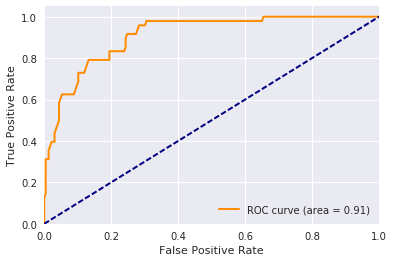

In [56]:
draw_roc(ROC_coord['FPR'],ROC_coord['TPR'])

Next we'll create a lift chart/table. Spark has a nufty function called QuantileDiscretizer that will do all the heavy lifting. We first need the predicted probabilities. We can use the transform function to get the test data set with the probabilities

In [58]:
test_data_predictions =  lr_model.transform(test_data)

In [64]:
test_data_predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|Churn|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[25.0,9672.03,5.4...|    0|[4.41471039278145...|[0.98804655614619...|       0.0|
|[26.0,8939.61,4.5...|    0|[6.07247498674469...|[0.99769984276055...|       0.0|
|[27.0,8628.8,5.3,...|    0|[5.61814888405608...|[0.99638178208687...|       0.0|
|[29.0,10203.18,5....|    0|[4.00878451449049...|[0.98216829313717...|       0.0|
|[30.0,10744.14,7....|    1|[2.02966613642464...|[0.88387681503562...|       0.0|
|[30.0,13473.35,3....|    0|[2.53336764201563...|[0.92644816096044...|       0.0|
|[31.0,5304.6,5.29...|    0|[2.91829030117372...|[0.94874322100595...|       0.0|
|[31.0,5387.75,6.8...|    0|[2.12051640821342...|[0.89288133101659...|       0.0|
|[31.0,7073.61,5.7...|    0|[2.69717312587216...|[0.93685963034663...|       0.0|
|[31.0,9574.89,7

In [63]:
test_data_predictions.printSchema()

root
 |-- features: vector (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



We see the proability column is in a vector format. By viewing this field we see thhat iit contains 2 probabilities: 
* the first element in the vector refers to the porability of experiencing a non-event (not to churn)
* the second element in the vector refers to the porability of experiencing an event (to churn)

We therefore need to extract the probability to churn

In [65]:
test_data_predictions.select('probability').show(n=2,truncate=False)

+-----------------------------------------+
|probability                              |
+-----------------------------------------+
|[0.9880465561461997,0.011953443853800268]|
|[0.9976998427605586,0.002300157239441353]|
+-----------------------------------------+
only showing top 2 rows



In [70]:
lift_input_table = test_data_predictions.withColumn('Probability_churn',secondelement(col('probability')))\
.select('Churn','Probability_churn')

In [456]:
lift_input_table.show()

+-----+--------------------+
|Churn|   Probability_churn|
+-----+--------------------+
|    0|0.011953443853800268|
|    0|0.002300157239441353|
|    0| 0.00361821791312011|
|    0|0.017831706862820977|
|    1| 0.11612318496437837|
|    0|  0.0735518390395507|
|    0| 0.05125677899404883|
|    0|  0.1071186689834003|
|    0| 0.06314036965336209|
|    0|0.043102872393604406|
|    0| 0.02248387137629221|
|    0| 0.05188913629071872|
|    0| 0.16645149067187462|
|    1| 0.23634044421718062|
|    1| 0.11586343560588541|
|    0|0.040144027835055794|
|    0| 0.05362364077925365|
|    0| 0.10568070142823519|
|    0|0.004414668518388807|
|    0| 0.01200884404511694|
+-----+--------------------+
only showing top 20 rows



Voila! Next we divide these probabilities into 10 deciles

In [71]:
deciles = QuantileDiscretizer(numBuckets=10,inputCol='Probability_churn',outputCol='Decile' )

In [72]:
lift_input_table2 =deciles.fit(lift_input_table).transform(lift_input_table)


In [73]:
lift_input_table2.show()

+-----+--------------------+------+
|Churn|   Probability_churn|Decile|
+-----+--------------------+------+
|    0|0.011953443853800268|   2.0|
|    0|0.002300157239441353|   0.0|
|    0| 0.00361821791312011|   0.0|
|    0|0.017831706862820977|   2.0|
|    1| 0.11612318496437837|   6.0|
|    0|  0.0735518390395507|   5.0|
|    0| 0.05125677899404883|   5.0|
|    0|  0.1071186689834003|   6.0|
|    0| 0.06314036965336209|   5.0|
|    0|0.043102872393604406|   4.0|
|    0| 0.02248387137629221|   3.0|
|    0| 0.05188913629071872|   5.0|
|    0| 0.16645149067187462|   7.0|
|    1| 0.23634044421718062|   7.0|
|    1| 0.11586343560588541|   6.0|
|    0|0.040144027835055794|   4.0|
|    0| 0.05362364077925365|   5.0|
|    0| 0.10568070142823519|   6.0|
|    0|0.004414668518388807|   1.0|
|    0| 0.01200884404511694|   2.0|
+-----+--------------------+------+
only showing top 20 rows



Next we count the number of customers that fall into each decile as well as the number of customers that churned per decile. 
We can easily have converted this dataframe to a pandas data frame, but this is to show Spark's data wrangling capabilities

In [75]:
exprs = [sum("Churn").alias('Number_churned'), count("Decile").alias('Number_customers')]

In [103]:
lift_table = lift_input_table2.groupBy('Decile').agg(*exprs).orderBy(desc('Decile'))
lift_table_pd = lift_table.toPandas()

In [88]:
lift_table_pd

,Decile,Number_churned,Number_customers
0,9.0,21,28
1,8.0,12,27
2,7.0,6,28
3,6.0,7,27
4,5.0,1,28
5,4.0,0,27
6,3.0,0,27
7,2.0,1,28
8,1.0,0,27
9,0.0,0,27


In [104]:
lift_table_pd['prop_churned'] = lift_table_pd['Number_churned']/lift_table_pd['Number_customers']

Next we'll calcuate the lift per decile

In [105]:
overall_takeup =lift_table_pd['Number_churned'].sum()/lift_table_pd['Number_customers'].sum()

In [106]:
lift_table_pd['prop_of_churn'] = lift_table_pd['Number_churned']/np.sum(lift_table_pd['Number_churned'])

In [107]:
lift_table_pd['Cummulative_churn']= lift_table_pd['prop_of_churn'].cumsum()

In [108]:
lift_table_pd['Lift']= lift_table_pd['prop_churned']/overall_takeup

In [109]:
lift_table_pd

,Decile,Number_churned,Number_customers,prop_churned,prop_of_churn,Cummulative_churn,Lift
0,9.0,21,28,0.750000,0.437500,0.437500,4.281250
1,8.0,12,27,0.444444,0.250000,0.687500,2.537037
2,7.0,6,28,0.214286,0.125000,0.812500,1.223214
3,6.0,7,27,0.259259,0.145833,0.958333,1.479938
4,5.0,1,28,0.035714,0.020833,0.979167,0.203869
5,4.0,0,27,0.000000,0.000000,0.979167,0.000000
6,3.0,0,27,0.000000,0.000000,0.979167,0.000000
7,2.0,1,28,0.035714,0.020833,1.000000,0.203869
8,1.0,0,27,0.000000,0.000000,1.000000,0.000000
9,0.0,0,27,0.000000,0.000000,1.000000,0.000000


Nice! We can immediately see that customers in the top decile has more than 4 times the likelihood to churn compared
to the baseline. The top decile also contains 75% of customers who churned. Next we can draw up a lift graph containing all this info

/opt/anaconda2/envs/py345/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


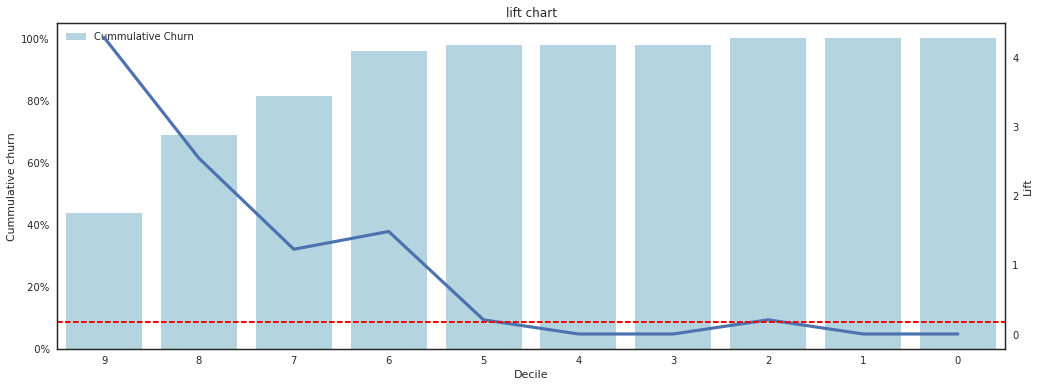

In [151]:
plt.close()

sns.set_style(style='white')
    
f, ax = plt.subplots(figsize=(17, 6))
    
sns.barplot(x='Decile',y='Cummulative_churn',data=lift_table_pd,label='Cummulative Churn',order=range(9,-1,-1),color='lightblue')
ax2 = ax.twinx()
sns.pointplot(x='Decile', y='Lift', data=lift_table_pd, ax=ax2,markers='',label='Lift',order=range(9,-1,-1))
ax.set(ylabel='Cummulative churn')
ax2.set(ylabel='Lift')
sns.plt.title('lift chart')
ax.legend(ncol=2, loc=2)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
x = plt.gca().axes.get_xlim()
plt.plot(x, len(x) * [overall_takeup], lw=2, linestyle='--',color='red',label='test')
         
plt.show()

This model is rank ordering more or less- i.e the lift is monotone decreasing except for a few bumps due to the small sample size

Once we are happy, we fit the model on the whole base and productionalise to score new data

In [152]:
final_lr_model = LogisticRegression(featuresCol = 'features',labelCol= 'Churn',).fit(model_input_data)

We now get new data we wan't to score

In [153]:
new_data = spark.read.csv('/user/a208669/new_customers.csv',inferSchema=True,header=True )

In [154]:
new_data.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)



In [344]:
new_data_to_score = assembler.transform(new_data).select('Names','Company','features')
new_data_pred = final_lr_model.transform(new_data_to_score)

In [345]:
new_data_pred.show()

+--------------+----------------+--------------------+--------------------+--------------------+----------+
|         Names|         Company|            features|       rawPrediction|         probability|prediction|
+--------------+----------------+--------------------+--------------------+--------------------+----------+
| Andrew Mccall|        King Ltd|[37.0,9935.53,7.7...|[2.41832366013597...|[0.91821394450559...|       0.0|
|Michele Wright|   Cannon-Benson|[23.0,7526.94,9.2...|[-5.9906678174824...|[0.00249574827398...|       1.0|
|  Jeremy Chang|Barron-Robertson|[65.0,100.0,1.0,1...|[-3.4325297516674...|[0.03129415226295...|       1.0|
|Megan Ferguson|   Sexton-Golden|[32.0,6487.5,9.4,...|[-5.3429693908695...|[0.00475889563977...|       1.0|
|  Taylor Young|        Wood LLC|[32.0,13147.71,10...|[1.28437178442218...|[0.78319303188952...|       0.0|
| Jessica Drake|   Parks-Robbins|[22.0,8445.26,3.4...|[-1.4385210975368...|[0.19177446955641...|       1.0|
+--------------+------------

We see that from the 6 new customers that we scored, 4 have a high likelihood of churning